In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from numpy import pi, sin, cos, arcsin, dot

class ThinFilm_model:
    def __init__(self, ambient, thinfilm, substrate, wl, angle = 0):
        self.wavelength = wl
        self.ambient = chromatic_n(ambient['a'], self.wavelength)
        self.substrate = chromatic_n(substrate['s'], self.wavelength)
        self.thinfilm = thinfilm
        self.angle = angle*pi/180
        
    def eq_tf_matrix(self, pl):
        eq_matrix = identity_matrix(self.wavelength)
        for i in range(np.size(self.thinfilm)):
            eq_matrix = matrix_dot(
                tf_matrix(self.thinfilm[-i-1], self.wavelength, 
                          pl, self.ambient, self.angle), eq_matrix)
        return eq_matrix

    def eq_admittance(self, pl):
        eq_matrix = self.eq_tf_matrix(pl)
        theta_s = arcsin(self.ambient/self.substrate*sin(self.angle))
        if pl == "S":
            eq_y = bc(eq_matrix, self.substrate*cos(theta_s)/cos(self.angle), wl)
        elif pl == "P":
            eq_y = bc(eq_matrix, self.substrate*cos(self.angle)/cos(theta_s), wl)
        else:
            eq_y = bc(eq_matrix, self.substrate, wl)
        Y = eq_y['C']/eq_y['B']
        return Y.values.reshape(np.size(self.wavelength), 1)
        
    def reflectance(self, pl):
        eq_Y = self.eq_admittance(pl).flatten()
        r = (self.ambient-eq_Y)/(self.ambient+eq_Y)
        reflectance = np.reshape(r*r.conjugate(), np.size(eq_Y))
        return np.real(reflectance)
    
    def R(self):
        if self.angle != 0:
            R_S = self.reflectance("S")
            R_P = self.reflectance("P")
            return oblique_incident(R_S, R_P)
        else:
            R = self.reflectance("non")
            return oblique_incident(R, R)

class oblique_incident:
    def __init__(self, S, P):
        self.S = S
        self.P = P
        self.avg = S+P/2
    
def bc(eq, ns, wl):
    m = np.size(wl)
    ita_s = np.reshape(pd.DataFrame({"one":np.ones(m),"ita":ns}).values.reshape(-1, 1), (m, 2, 1))
    YY = [dot(eq[i], ita_s[i]) for i in range(m)]
    bc = pd.DataFrame(np.reshape(YY, (m,2)), columns = ['B','C'])
    return bc

def chromatic_n(m, wl, pl=0, n0=0, theta0=0):
    n, k = globals()[material[m]['type']](material[m], wl)
    theta_n = arcsin(n0*sin(theta0)/n)
    if pl == "S":
        return (n - 1j*k)*cos(theta_n)/cos(theta0)
    elif pl == "P":
        return (n - 1j*k)*cos(theta0)/cos(theta_n)
    else:
        return n - 1j*k

def tf_matrix(layer, wl, pl, n0, theta0):
    m = matrix(layer['m'], layer['d'], wl, pl, n0, theta0)
    return m

def matrix(m, t, wl, pl, n0, theta0):
    ita = chromatic_n(m, wl, pl, n0, theta0) 
    if pl == "S" or pl == "P":
        delta = 2*pi*ita*t/wl*cos(theta0)
    else:
        delta = 2*pi*ita*t/wl
    element = matrix_element(ita, delta)
    return np.reshape(element.values.reshape(1,-1), (np.size(wl), 2, 2))

def matrix_element(ita, delta):
    e = pd.DataFrame(
        {'e1':cos(delta), 'e2':1j/ita*sin(delta), 
         'e3':1j*ita*sin(delta), 'e4':cos(delta)})
    return e
    
def matrix_dot(layer_up, layer_bot): 
    w, _, _ = np.shape(layer_up)
    eq = [dot(layer_up[i], layer_bot[i]) for i in range(w)]
    return eq

def identity_matrix(wl):
    m = np.size(wl)
    i = pd.DataFrame({'e1':np.ones(m), 'e2':np.zeros(m), 'e3':np.zeros(m), 'e4':np.ones(m)})
    i_matrix = np.reshape(i.values.reshape(1,-1), (m, 2, 2))
    return i_matrix

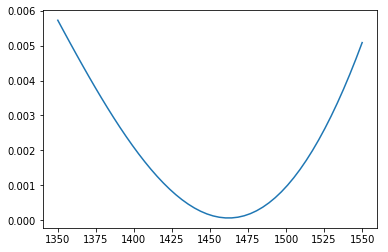

In [200]:
wl = np.linspace(1350, 1550)
AR_coating_test = ThinFilm_model(
    {'a': "air"},
    [{'m':'SiO2', 'd':208.05180068},
     {'m':'TiO2', 'd':263.34367992}],
    {'s': 'CrYAG'}, wl, 5)
x = AR_coating_test.substrate
R = AR_coating_test.R().avg
plt.plot(wl, R)
plt.show()

In [197]:
material = {
    'TiO2':{'A':5.913, 'B':0.2441, 'C':0.0803, 'type':'TiO2'},
    'SiO2':{'A':0.6961663,'B':0.0684043,'C':0.4079426,'D':0.1162414,'E':0.8974794,'F':9.896161, 'type':'SiO2'},
    'glass':{'type':'glass', 'material':'glass'},
    'air':{'type':'air', 'material':'air'},
    'ITO':{'type':'ITO', 'material':'ITO'},
    'SiN':{'type':'SiN', 'material':'SiN'},
    'acrylic':{'A':1.1819, 'B':0.011313, 'type':'acrylic'},
    'acrylic_h':{'type':'acrylic_h'},
    'polymide':{'type':'polymide'},
    'CrYAG':{'type':'CrYAG'}
}
def ITO(m, x):
    file = pd.read_csv('{}.csv'.format(m['material']))
    f_n = interp1d([float(i) for i in file[:381]['wl']], [float(i) for i in file[:381]['n']])
    f_k = interp1d([float(i) for i in file[:381]['wl']], [float(i) for i in file[382:]['n']])
    return f_n(x/1000), f_k(x/1000)

def SiN(m,x):
    file = pd.read_csv('{}.csv'.format(m['material']))
    f_n = interp1d([float(i) for i in file[:146]['wl']], [float(i) for i in file[:146]['n']])
    f_k = interp1d([float(i) for i in file[:146]['wl']], [float(i) for i in file[147:]['n']])
    return f_n(x/1000), f_k(x/1000)

def TiO2(m, x):
    x = x/1000
    n = (m['A']+m['B']/(x**2-m['C']))**.5
    k = np.zeros(np.size(x))
    return n, k

def SiO2(m, x):
    x = x/1000
    n = (1+m['A']/(1-(m['B']/x)**2)+m['C']/(1-(m['D']/x)**2)+m['E']/(1-(m['F']/x)**2))**.5
    k = np.zeros(np.size(x))
    return n, k

def acrylic(m, x):
    x = x/1000
    n = (1+m['A']/(1-m['B']/x**2))**.5
    k = np.zeros(np.size(x))
    return n, k

def acrylic_h(m, x):
    n = 1.8*np.ones(np.size(x))
    k = 0*np.ones(np.size(x))
    return n, k

def CrYAG(m, x):
    n = 1.8*np.ones(np.size(x))
    k = 0*np.ones(np.size(x))
    return n, k

def polymide(m, x):
    n = 1.5*np.ones(np.size(x))
    k = np.zeros(np.size(x))
    return n, k

def glass(m, x):
    n = 1.5*np.ones(np.size(x))
    k = np.zeros(np.size(x))
    return n, k

def air(m, x):
    n = np.ones(np.size(x))
    k = np.zeros(np.size(x))
    return n, k

def sec_reflec(T_measure, n0, ns):
    T_sec = 1-((n0-ns)/(n0+ns))**2
    return (100/T_measure - 1/T_sec + 1)**-1

def trans(n0, n1):
    return 1-((n0-n1)/(n0+n1))**2

In [199]:
from scipy.optimize import minimize, basinhopping

def FoM(D):
    d1 = D[0]
    d2 = D[-1]
    wl = np.linspace(1350, 1550)
    R_target = np.zeros(np.size(wl))
    AR_coating = ThinFilm_model(
        {'a':"air"}, [{'m':'SiO2', 'd':d2},{'m':'TiO2', 'd':d1}],{'s':'CrYAG'}, wl, 5)
    hofx = AR_coating.R().avg
    target = R_target
    return 100* sum(abs(hofx-target))
basinhopping(FoM, [200, 300])

                        fun: 10.045443236867138
 lowest_optimization_result:       fun: 10.045443236867138
 hess_inv: array([[ 7.15295677,  3.11674599],
       [ 3.11674599, 13.79369834]])
      jac: array([-1.1920929e-07, -1.1920929e-07])
  message: 'Optimization terminated successfully.'
     nfev: 36
      nit: 7
     njev: 9
   status: 0
  success: True
        x: array([263.34367992, 208.05180068])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 3692
                        nit: 100
                       njev: 923
                          x: array([263.34367992, 208.05180068])

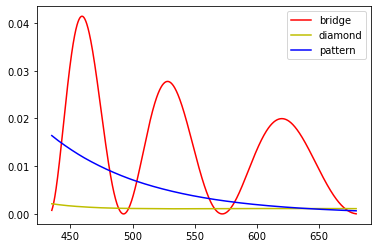

In [4]:
d_SiN = 10
d_SiO2 = 50
bridge = ThinFilm_model(
    {'a': 1.5}, [
        {'m': 'polymide', 'd': 800},
        {'m': 'SiN', 'd': d_SiN},
        {'m': 'SiO2', 'd':d_SiO2},
        {'m': 'ITO', 'd':23},
        {'m': 'acrylic', 'd':1200},
        {'m': 'ITO', 'd':23},
        {'m': 'SiO2', 'd':d_SiO2},
        {'m': 'SiN', 'd': d_SiN}
    ], {'s': 1.5})

ITO_layer = ThinFilm_model(
    {'a': 1.5}, [
        {'m': 'polymide', 'd': 2000},
        {'m': 'SiN', 'd': d_SiN},
        {'m': 'SiO2', 'd':d_SiO2},
        {'m': 'ITO', 'd':23},
        {'m': 'SiO2', 'd':d_SiO2},
        {'m': 'SiN', 'd': d_SiN}
    ], {'s': 1.5})

pattern = ThinFilm_model(
    {'a': 1.5}, [
        {'m': 'polymide', 'd': 2000},
        {'m': 'SiN', 'd': d_SiN},
        {'m': 'SiO2', 'd':d_SiO2},
        {'m': 'SiO2', 'd':d_SiO2},
        {'m': 'SiN', 'd': d_SiN}
    ], {'s': 1.5})

start_wl = 435
end_wl = 680
wl = np.linspace(start_wl, end_wl, 1000)
R_b = bridge.R(wl)
R_ITO = ITO_layer.R(wl)
R_p = pattern.R(wl)

plt.plot(wl, R_b, 'r',label = 'bridge', )
plt.plot(wl, R_ITO, 'y', label = 'diamond')
plt.plot(wl, R_p, 'b', label = 'pattern')
plt.legend(loc = 'best')
plt.savefig('model.png')
plt.show()

In [5]:
T_OCA_GG3 = trans(1.48, 1.47)
file = pd.read_csv(r'.\DX\Glass_0T.csv')
file_c = pd.read_csv(r'.\DX\DX-MP-1_0T.csv')
wl = file['nm']
TA_glass = sec_reflec(file['SCAN'], 1, 1.47)
TA_DX = sec_reflec(file_c['SCAN'], 1, 1.47)
f_gg3 = interp1d(wl, TA_glass)
f_dx = interp1d(wl, TA_DX)